<a href="https://colab.research.google.com/github/j-min/IterInpaint/blob/main/inference_iterinpaint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

In [ ]:
!git clone https://github.com/j-min/IterInpaint

In [ ]:
cd IterInpaint

In [ ]:
!pip uninstall -y torchtext

In [ ]:
!pip install -r requirements.txt

In [1]:
import argparse, os, sys, glob, re
import json
import torch
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid, save_image
import time
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import contextmanager, nullcontext

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

from transformers import CLIPTokenizer, CLIPTextModel
from pathlib import Path

In [2]:
def parse(argument):
    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--prompt",
        type=str,
        nargs="?",
        default="a painting of a virus monster playing guitar",
        help="the prompt to render"
    )
    parser.add_argument(
        "--outdir",
        type=str,
        nargs="?",
        help="dir to write results to",
        default="outputs/txt2img-samples"
    )
    parser.add_argument(
        "--skip_grid",
        action='store_true',
        help="do not save a grid, only individual samples. Helpful when evaluating lots of samples",
    )
    parser.add_argument(
        "--skip_save",
        action='store_true',
        help="do not save individual samples. For speed measurements.",
    )
    parser.add_argument(
        "--ddim_steps",
        type=int,
        default=50,
        help="number of ddim sampling steps",
    )
    parser.add_argument(
        "--plms",
        action='store_true',
        help="use plms sampling",
    )
    parser.add_argument(
        "--laion400m",
        action='store_true',
        help="uses the LAION400M model",
    )
    parser.add_argument(
        "--fixed_code",
        action='store_true',
        help="if enabled, uses the same starting code across samples ",
    )
    parser.add_argument(
        "--ddim_eta",
        type=float,
        default=0.0,
        help="ddim eta (eta=0.0 corresponds to deterministic sampling",
    )
    parser.add_argument(
        "--n_iter",
        type=int,
        default=2,
        help="sample this often",
    )
    parser.add_argument(
        "--H",
        type=int,
        default=512,
        help="image height, in pixel space",
    )
    parser.add_argument(
        "--W",
        type=int,
        default=512,
        help="image width, in pixel space",
    )
    parser.add_argument(
        "--C",
        type=int,
        default=4,
        help="latent channels",
    )
    parser.add_argument(
        "--f",
        type=int,
        default=8,
        help="downsampling factor",
    )
    parser.add_argument(
        "--n_samples",
        type=int,
        default=3,
        help="how many samples to produce for each given prompt. A.k.a. batch size",
    )
    parser.add_argument(
        "--n_rows",
        type=int,
        default=0,
        help="rows in the grid (default: n_samples)",
    )
    parser.add_argument(
        "--scale",
        type=float,
        default=7.5,
        help="unconditional guidance scale: eps = eps(x, empty) + scale * (eps(x, cond) - eps(x, empty))",
    )
    parser.add_argument(
        "--from-file",
        type=str,
        help="if specified, load prompts from this file",
    )
    parser.add_argument(
        "--config",
        type=str,
        default="configs/stable-diffusion/v1-inference-box.yaml",
        help="path to config which constructs model",
    )
    parser.add_argument(
        "--ckpt",
        type=str,
        default="models/ldm/stable-diffusion-v1/model.ckpt",
        help="path to checkpoint of model",
    )    
    parser.add_argument(
        "--seed",
        type=int,
        default=42,
        help="the seed (for reproducible sampling)",
    )
    parser.add_argument(
        "--precision",
        type=str,
        help="evaluate at this precision",
        choices=["full", "autocast"],
        default="autocast"
    )
    parser.add_argument(
        "--embedding_path", 
        type=str, 
        help="Path to a pre-trained embedding manager checkpoint")

    opt = parser.parse_args(argument)
    return opt

In [3]:
opt = parse(
"""
--plms --scale 4.0 --n_iter 1 --ddim_steps 50 --outdir outputs/
--n_samples 1 
""".split())

In [4]:
opt

Namespace(prompt='a painting of a virus monster playing guitar', outdir='outputs/', skip_grid=False, skip_save=False, ddim_steps=50, plms=True, laion400m=False, fixed_code=False, ddim_eta=0.0, n_iter=1, H=512, W=512, C=4, f=8, n_samples=1, n_rows=0, scale=4.0, from_file=None, config='configs/stable-diffusion/v1-inference-box.yaml', ckpt='models/ldm/stable-diffusion-v1/model.ckpt', seed=42, precision='autocast', embedding_path=None)

In [5]:
opt.config = "configs/stable-diffusion/v1-inference-iterinpaint.yaml"

# Download Pretrained Checkpoint

In [ ]:
!mkdir -p checkpoints
!wget https://huggingface.co/j-min/IterInpaint-CLEVR-original/resolve/main/iterinpaint_CLEVR_FG30.ckpt -O checkpoints/iterinpaint_CLEVR_FG30.ckpt

In [6]:
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

In [7]:
opt.ckpt = 'checkpoints/iterinpaint_CLEVR_FG30.ckpt'

In [8]:
seed_everything(opt.seed)

from transformers import logging
logging.set_verbosity_error()


config = OmegaConf.load(f"{opt.config}")
model = load_model_from_config(config, f"{opt.ckpt}")

Global seed set to 42


Loading model from checkpoints/iterinpaint_CLEVR_FG30.ckpt
Global Step: 20000
LatentInpaintDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.54 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded CLIP text model - openai/clip-vit-large-patch14
Added 1000 bbox bin tokens to tokenizer


In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

In [10]:
from ldm.gen_utils import inference_from_custom_annotation, encode_from_custom_annotation
from ldm.viz_utils import plot_results, fig2img, show_images

# Define a custom layout

In [11]:
layout_name = "eight_objects_two_rows"
custom_annotations = [
    {'x': 19,
     'y': 61,
     'width': 158,
     'height': 169,
     'label': 'blue metal cube'},
    {'x': 183,
      'y': 94,
      'width': 103,
      'height': 109,
      'label': 'brown rubber sphere'},
    {'x': 289,
     'y': 112,
     'width': 82,
     'height': 77,
     'label': 'gray metal sphere'},
    {'x': 374,
      'y': 128,
      'width': 48,
      'height': 46,
      'label': 'yellow rubber cylinder'},
    {'x': 22,
      'y': 346,
      'width': 82,
      'height': 73,
      'label': 'gray metal cylinder'},
    {'x': 110,
      'y': 326,
      'width': 107,
      'height': 102,
      'label': 'cyan rubber sphere'},
    {'x': 218,
      'y': 313,
      'width': 124,
      'height': 125,
      'label': 'green rubber cube'},
    {'x': 343,
      'y': 295,
      'width': 164,
      'height': 179,
      'label': 'red metal cylinder'},
]

In [12]:
# 1) convert xywh to xyxy
# 2) normalize coordinates
scene = encode_from_custom_annotation(custom_annotations, size=512)

print(scene['boxes_normalized'])
print(scene['box_captions'])

[[0.037109375, 0.119140625, 0.345703125, 0.44921875], [0.357421875, 0.18359375, 0.55859375, 0.396484375], [0.564453125, 0.21875, 0.724609375, 0.369140625], [0.73046875, 0.25, 0.82421875, 0.33984375], [0.04296875, 0.67578125, 0.203125, 0.818359375], [0.21484375, 0.63671875, 0.423828125, 0.8359375], [0.42578125, 0.611328125, 0.66796875, 0.85546875], [0.669921875, 0.576171875, 0.990234375, 0.92578125]]
['blue metal cube', 'brown rubber sphere', 'gray metal sphere', 'yellow rubber cylinder', 'gray metal cylinder', 'cyan rubber sphere', 'green rubber cube', 'red metal cylinder']


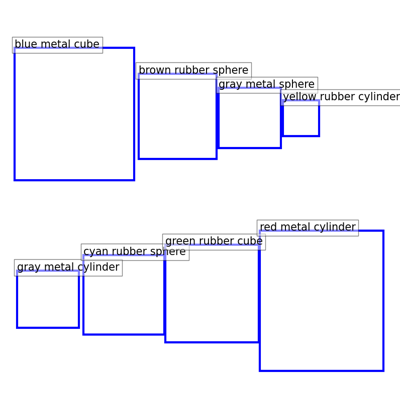

In [13]:
layout_img = fig2img(plot_results(
    Image.new('RGB', (512, 512), color='white'),
    boxes=scene['boxes_normalized'],
    captions=scene['box_captions'],
    colors=['blue'] * len(scene['box_captions'])
))
layout_img.resize((400,400))

# Generate Image

In [14]:
# Create Diffusion sampler
if opt.plms:
    sampler = PLMSSampler(model)
else:
    sampler = DDIMSampler(model)

# Use Crop & Paste
opt.iterinpaint_nopaste = False

# With 'box_generation_order = None, the objects are generated in the order of 'custom_annotations'
opt.box_generation_order = None

In [15]:
opt.verbose = True

In [16]:
out = inference_from_custom_annotation(custom_annotations, sampler, opt)

prompt: Add blue metal cube
prompt: 
prompt: Add brown rubber sphere
prompt: 
prompt: Add gray metal sphere
prompt: 
prompt: Add yellow rubber cylinder
prompt: 
prompt: Add gray metal cylinder
prompt: 
prompt: Add cyan rubber sphere
prompt: 
prompt: Add green rubber cube
prompt: 
prompt: Add red metal cylinder
prompt: 
prompt: Add gray background
prompt: 


Context images


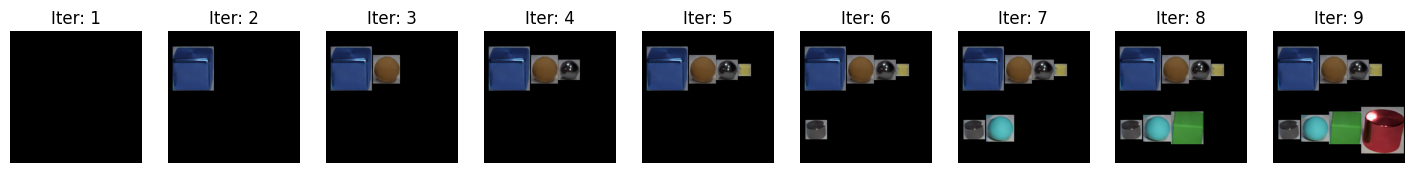

Masks - Black: preserved | White: repainted


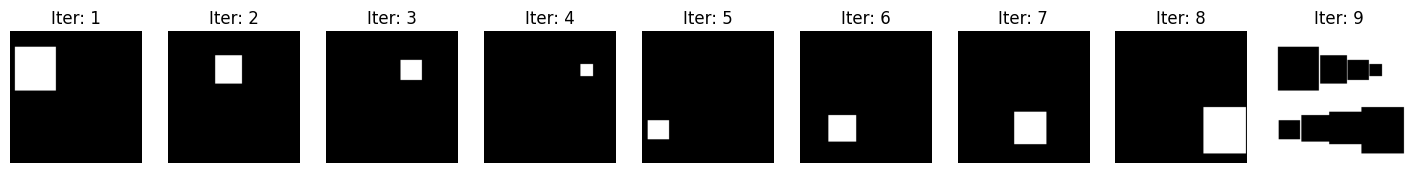

Generated_images


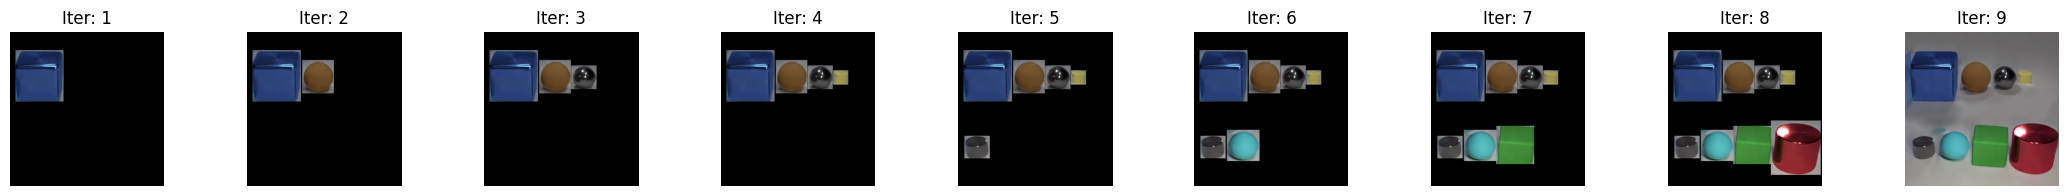

Generated_images - title: prompts


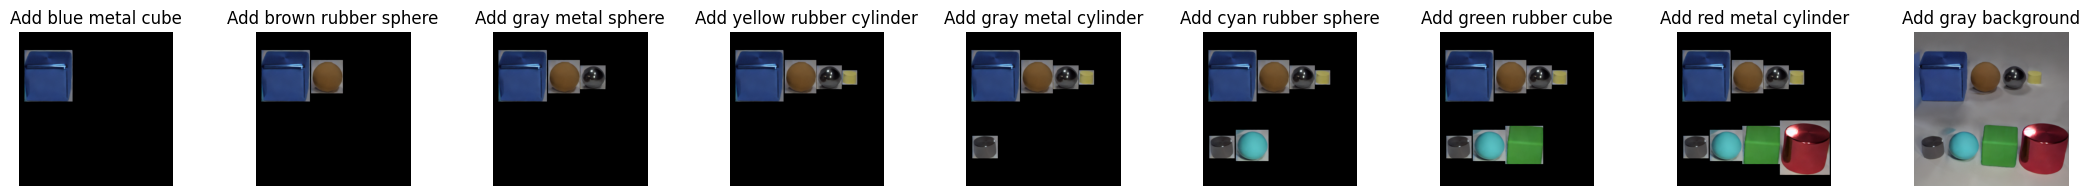

In [17]:
context_imgs = out['context_imgs']
prompts = out['prompts']
mask_imgs = out['mask_imgs']
generated_images = out['generated_images']

print('Context images')
show_images(context_imgs)
plt.show()
plt.close()


print('Masks - Black: preserved | White: repainted')
show_images(mask_imgs, gray=True)
plt.show()
plt.close()


print('Generated_images')
show_images(generated_images, w=3)
plt.show()
plt.close()

print('Generated_images - title: prompts')
show_images(generated_images, w=3, title=prompts)
plt.show()
plt.close()